In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error
from IPython import display
import time
from torch.utils.data import DataLoader, Dataset

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [3]:
# The data is in https://drive.google.com/file/d/1n9gjLCxzFe8N2QbHeZkDtswlSdNyJpEs/view?usp=drive_link
test_data = np.load("test_dataset.npy")
print("Test data shape: ", test_data.shape)
np.max(test_data)

Test data shape:  (4, 320, 256, 256)


np.float32(1.0)

In [4]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.middle = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU())
        self.conv_up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.conv_up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        down1 = self.down1(x)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        middle = self.middle(pool2)

        up1 = self.up1(middle)
        up1 = torch.cat((up1, down2), dim=1)
        up1 = self.conv_up1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat((up2, down1), dim=1)
        up2 = self.conv_up2(up2)

        return self.final(up2)

In [5]:
'''
Reading the pretrained parameters
'''
model = SimpleUNet()
# The pretrained model is in https://drive.google.com/file/d/16W_aeHeB-yBHSFRfo1ILJh3DbahkUiRT/view?usp=drive_link
state_dict = torch.load('trained_model_unconditional.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

In [6]:
def denoise(guidance, model, K, beta_min = 1e-4, beta_max = 0.02, steps=[1000], output_freq=10, show_intermediate_output=False):
    for i in range(K):
        betas = torch.linspace(beta_min, beta_max, steps[i]).to(device)
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        epsilon = torch.randn_like(guidance).to(device)
        x_t = torch.sqrt(alphas_cumprod[steps[i]-1]) * guidance + \
        torch.sqrt(1 - alphas_cumprod[steps[i]-1]) * epsilon
        for t in reversed(range(1, steps[i]+1)):
            assert x_t.shape[1] == 1, f"Error: The channel of x_t != 1."  # Make sure the input is a single channel snapshot
            if show_intermediate_output and (t%output_freq == 0 or t == 1):
                plt.imshow(x_t.squeeze().cpu())
                display.display(plt.gcf())
                display.clear_output(wait=True)
                time.sleep(0.01)
                
            # Calculate the parameters
            alpha_t_bar = alphas_cumprod[t-1]
            beta_t = betas[t-1]
            alpha_t = alphas[t-1]
            # Predict the noise using the model
            with torch.no_grad():
                epsilon_theta = model(x_t)

            # Make sure the output of the model (the predicted noise) has a single channel
            assert epsilon_theta.shape[1] == 1, "Error: The channel of epsilon_theta != 1."
            # Calculate the mean of the previous step in the backward process of diffusion model
            mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_t_bar)) * epsilon_theta)
            # Add noise for all but the last step (strictly follow the algorithm)
            if t > 1:
                # z = torch.randn_like(x_t).to(device)
                z = torch.randn_like(x_t).to(device)
                x_t = mean + torch.sqrt(beta_t) * z
            else:
                x_t = mean

        guidance = x_t
        #plt.show()
    return x_t

(4, 220, 1024)


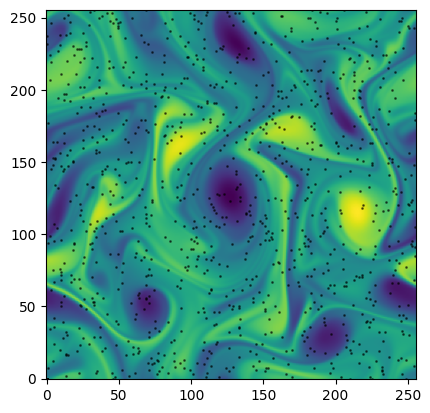

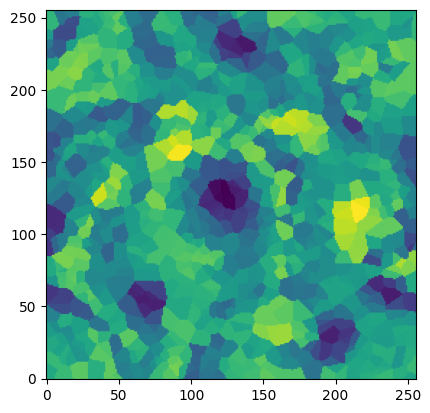

In [20]:
#Randomly choose a fixed percentage of points from the test snapshot
percentage = 1.5625
factor = percentage/100
start_idx = 100
end_idx = 320
N = int(256**2 * factor)
test_snapshots = test_data[:, start_idx : end_idx]
nx = np.random.randint(0, 256, (N,))
ny = np.random.randint(0, 256, (N,))
sparse_measurement =  test_snapshots[..., nx, ny]

#Nearest neighbor interpolation
xx,yy = np.meshgrid(np.arange(256), np.arange(256))
coordinates = np.vstack((nx, ny)).T
#interpolated_sparse_measurement = interpolate.griddata(coordinates, sparse_measurement, (xx,yy), method='nearest').T
sparse_measurement_list = []
print(sparse_measurement.shape)
for i in range(sparse_measurement.shape[0]):
    sl_list = []
    for j in range(sparse_measurement.shape[1]):
        sl_list.append(interpolate.griddata(coordinates, sparse_measurement[i,j], (xx,yy), method='nearest').T)
    sparse_measurement_list.append(sl_list)

interpolated_sparse_measurement = np.array(sparse_measurement_list)

#Visualize location of selected points and interpolated sparse measurements
figure,ax = plt.subplots()
figure2,ax2 = plt.subplots()
ax.imshow(test_snapshots[0,0])
mask = np.zeros((256, 256))
mask[nx, ny] = 1
ax.scatter(xx*mask, yy*mask, s=1, c="black", alpha=0.5)
ax2.imshow(interpolated_sparse_measurement[0, 5])
ax.invert_yaxis()
ax2.invert_yaxis()
ax2.set_title("")
figure.savefig("Enforcement_Line.png", dpi=400)
figure2.savefig("Enforcement_Line_Upscaled.png", dpi=400)
#Choose one of the four trajectories
trajectory = 3
#sparse_measurement = torch.tensor(interpolated_sparse_measurement[trajectory],  dtype=torch.float32).unsqueeze(1).to(device)

In [21]:
class NumpyDataset(Dataset):
    def __init__(self, data):
        # Reshape the data to create individual samples
        self.data = data.reshape(-1, 256, 256)
        # Normalize the data to [-1, 1]
        #self.data = 2 * (self.data - np.min(self.data)) / (np.max(self.data) - np.min(self.data)) - 1
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = np.expand_dims(image, axis=0)  # Add channel dimension
        return torch.tensor(image, dtype=torch.float32)
guidance_dataset = NumpyDataset(interpolated_sparse_measurement[trajectory].squeeze())
# Select 10% of the dataset
guidance_dataloader = DataLoader(guidance_dataset, batch_size=20, shuffle=False)


In [22]:
def denoise_dataloader(guidance_dataloader, model, K, beta_max = 0.02, steps=[1000], output_freq=10):
    images = []
    for i, guidance in enumerate(guidance_dataloader):
        print(i)
        guidance = torch.tensor(guidance).to(device)
        generated_image = denoise(guidance, model, K=K, beta_max=beta_max, steps=steps, output_freq=output_freq).reshape(-1,256,256).detach().cpu().numpy()
        images.append(generated_image)
    images = np.concatenate(images, axis=0)
    return images

#generates_samples = denoise_dataloader(guidance_dataloader, model, K=1, steps=[10])
#plt.imshow(generates_samples[0])

In [23]:
def two_point_corr(field, axis=0):
    number_of_cells = field.shape[axis]
    mean = np.mean(field)
    field_prime = field - mean
    var = np.var(field)
    f_corr = []
    for ii in range(number_of_cells // 2):
        f_corr_ii = np.mean(field_prime * np.roll(field_prime, shift=ii, axis=axis)) / var # longitudinal
        f_corr.append(f_corr_ii)
    f_corr = np.array(f_corr)
    return f_corr

K=1, S=50, 
0


/tmp/ipykernel_4234/4131101348.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guidance = torch.tensor(guidance).to(device)


1
2
3
4
5
6
7
8
9
10
(220, 256, 256)
K=1, S=100, 
0
1
2
3
4
5
6
7
8
9
10
(220, 256, 256)
K=1, S=200, 
0
1
2
3
4
5
6
7
8
9
10
(220, 256, 256)
K=1, S=400, 
0
1
2
3
4
5
6
7
8
9
10
(220, 256, 256)
[1. 1. 1. 1.] (100, 4) (100, 4)


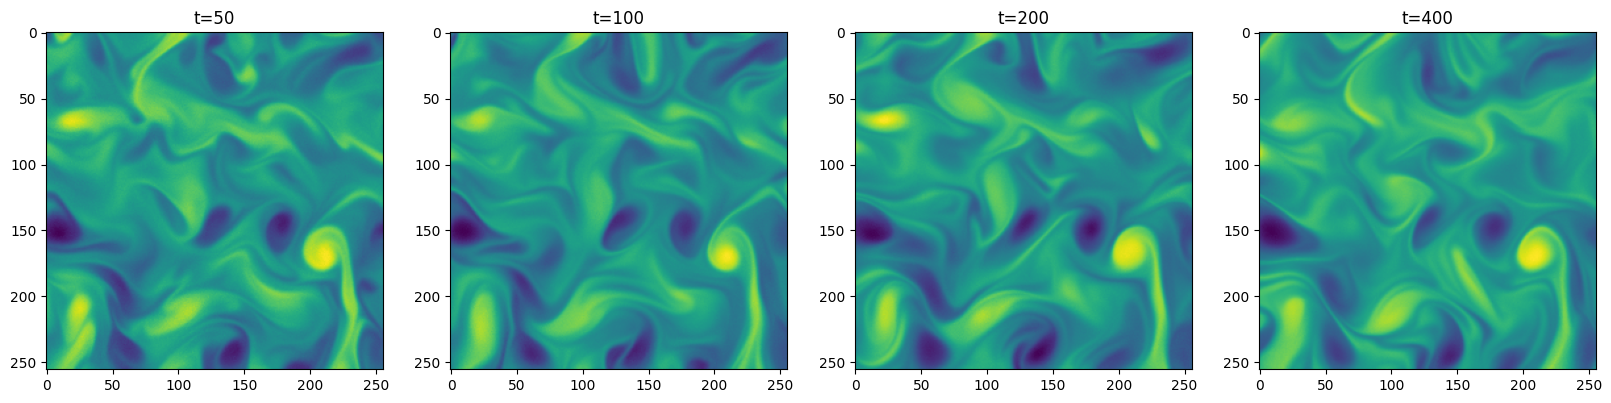

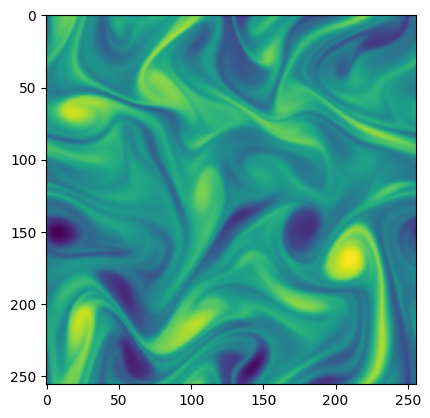

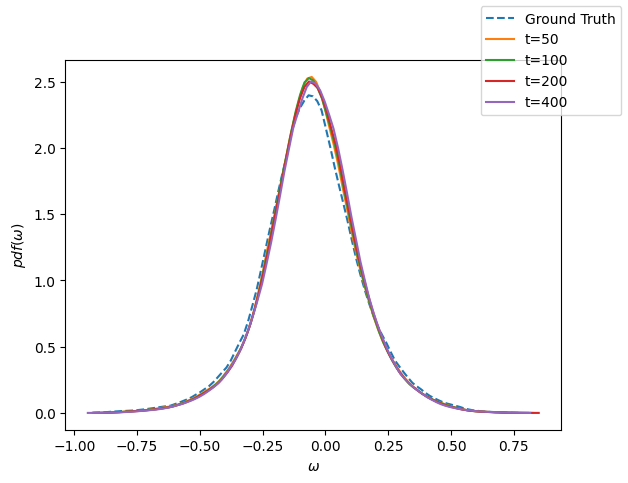

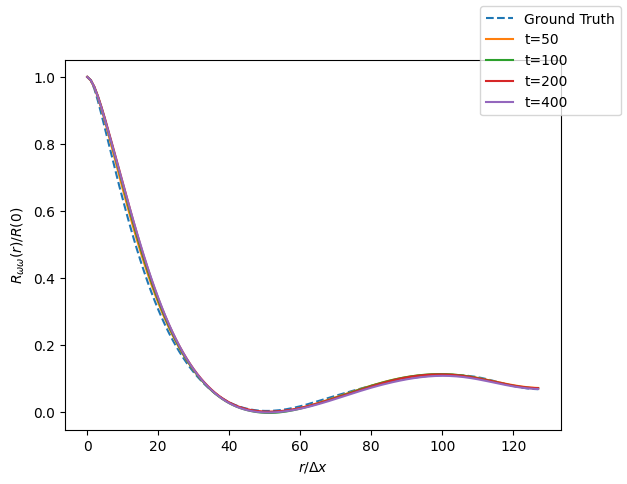

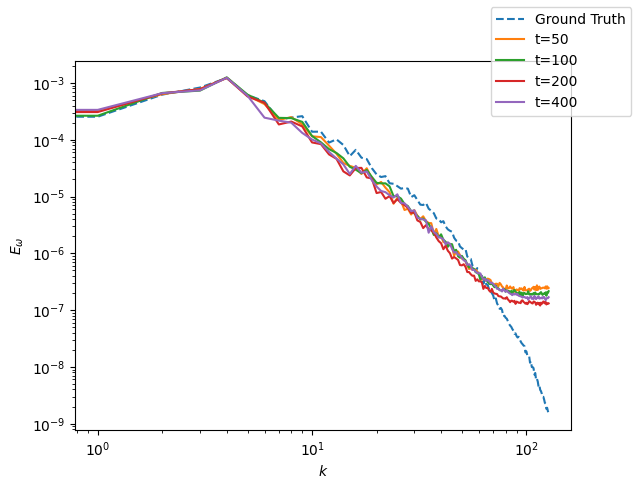

In [44]:
import os
from energy_spectrum import compute_tke_spectrum

#sparse_measurement = torch.tensor(interpolated_sparse_measurement, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

def parametric(K,S, beta_max):
    two_point_corr_list = []
    energy_spetrum_list = []
    pdf_list = []
    bins_list = []
    vars = {"K" : K, "t" : S, "beta_max" : beta_max}
    if len(S) > 1:
        size = len(S)
        title = r"t"
        independent_var = "t"
    elif len(beta_max) > 1:
        size = len(beta_max)
        title = r"$\beta_{max}$"
        independent_var = "beta_max"
    elif len(K) > 1:
        size = len(K)
        title = r"K"
        independent_var = "K"

    legend = ["Ground Truth"]
    fig_generated, ax_generated = plt.subplots(1,size, figsize=(20,20))
    fig_gt,ax_gt =  plt.subplots()
    for i in range(size):
        ax_generated[i].set_title(title + r"=" + str(vars[independent_var][i]))
        legend.append(title + r"=" + str(vars[independent_var][i]))
    i = 0
    for s in S:
        for k in K:
                for beta in beta_max:
                    print(f"K={k}, S={s}, ")
                    path_K = os.path.join(path, "K_" + str(k))
                    path_K_str = path + "K_" + str(k)
                    if not os.path.exists(path_K):
                        os.makedirs(path_K)
                    steps = np.ones((k,), dtype=np.int16) * s
                    generated_image = denoise_dataloader(guidance_dataloader, model,steps=steps, K=k, beta_max=beta, output_freq=10)
                    print(generated_image.shape)
                    ax_generated[i].imshow(generated_image[5])
                    two_point_corr_list.append(two_point_corr(generated_image, axis=1))
                    _,_, spectrum = compute_tke_spectrum(generated_image[5],1,1)
                    energy_spetrum_list.append(spectrum)
                    pdf, bins = np.histogram(generated_image.flatten(), bins=100)
                    pdf_list.append(pdf)
                    bins_list.append(bins)
                    i+=1
    ax_gt.imshow(test_snapshots[trajectory, 5])
    return np.array(two_point_corr_list), np.array(energy_spetrum_list), np.array(pdf_list), np.array(bins_list), legend, independent_var

S = [50, 100, 200, 400]
K = [1]
beta_max = [0.002]

path = "/home/baris/Documents/DDSim/baris-personal/sparse/"

two_point_corr_array, spectrum_generated_image, pdf, bins, legend, independent_var = parametric(K,S, beta_max)
figure, axis = plt.subplots()
#figure2, axis2 = plt.subplots()
figure3, axis3 = plt.subplots()
figure4, axis4 = plt.subplots()
axis4.set_xscale("log")
axis4.set_yscale("log")

#Compute statistical quantities for ground turth
nyquist, wave_numbers, spectrum_ground_truth = compute_tke_spectrum(test_snapshots[trajectory,5], 1,1)
#_, _, spectrum_sparse = compute_tke_spectrum(sparse_measurement[5].squeeze().detach().cpu().numpy(), 1,1)
nyquist = int(nyquist/(2*np.pi))
pdf_ground_truth, bins_gt = np.histogram(test_snapshots[trajectory].flatten(), bins=100)
bins = bins.T
dx = (np.max(test_snapshots[trajectory]) - np.min(test_snapshots[trajectory]))/100
dx_generated = bins[1:] - bins[:-1]
pdf = pdf.T/(test_snapshots[trajectory].size * dx_generated)
pdf_ground_truth = pdf_ground_truth/(test_snapshots[trajectory].size * dx)

two_point_corr_ground_truth = two_point_corr(test_snapshots[trajectory], axis=-2)

#Plot Statistical quantities

#Two point correlation
axis3.plot(two_point_corr_ground_truth.T, "--")
axis3.plot(two_point_corr_array.T)
axis3.set_xlabel(r"$r/\Delta x$")
axis3.set_ylabel(r"$R_{\omega\omega}(r)/R(0)$")
figure3.legend(legend, loc="upper right")

#spectrum
axis4.plot(np.arange(0,nyquist).astype(np.int16), spectrum_ground_truth.T[:nyquist], "--")
#axis4.plot(np.arange(0,nyquist).astype(np.int16), spectrum_sparse.T[:nyquist])
axis4.plot(np.arange(0,nyquist).astype(np.int16), spectrum_generated_image.T[:nyquist])
axis4.set_xlabel(r"$k$")
axis4.set_ylabel(r"$E_{\omega}$")
#axis4.plot(wave_numbers[5:40]/(2*np.pi), 8e-2 * wave_numbers[5:40]**(-2/3))
figure4.legend(legend, loc="upper right")

#Pdf
axis.plot((bins_gt[1:] + bins_gt[:-1])/2, pdf_ground_truth, "--")
axis.plot((bins[1:] + bins[:-1])/2, pdf)
figure.legend(legend, loc="upper right")
axis.set_xlabel(r"$\omega$")
axis.set_ylabel(r"$pdf(\omega)$")
print(np.sum(pdf*dx_generated, axis=0), (bins[1:] + bins[:-1]).shape, pdf.shape)

dpi=400
figure3.savefig("plots/Two_Point_Corr_" + independent_var + ".png", dpi=dpi)
figure4.savefig("plots/Spectrum_" + independent_var + ".png", dpi=dpi)
figure.savefig("plots/PDF_" + independent_var + ".png", dpi=dpi)

In [88]:
np.save("arrays/pdf.npy", pdf)
np.save("arrays/correlation.npy", two_point_corr_array)
np.save("arrays/spectrum.npy", spectrum_generated_image)

In [95]:
K = 1
steps = np.ones((K,), dtype=np.int16) * 100#
idx =  np.random.randint(0, 20)
snapshot = test_snapshots[trajectory,idx]
print(sparse_measurement.shape)

sparse_measurement_sample = sparse_measurement[idx].unsqueeze(0)
print(sparse_measurement_sample.shape)

enforced_measurements = []
n = 100
for i in range(n):
    generated_image = denoise(sparse_measurement_sample, model,steps=steps, K=1, beta_max=0.002, output_freq=10, show_intermediate_output=False).squeeze().detach().cpu().numpy()
    enforced_measurements.append(generated_image[nx,ny])
enforced_measurements = np.array(enforced_measurements)
print(enforced_measurements.shape)


(4, 220, 1024)


IndexError: index 15 is out of bounds for axis 0 with size 4

In [86]:

from matplotlib.lines import Line2D

idx_sparse_measurement = 0#np.random.randint(0,50)
addition = 128
print(enforced_measurements.shape)
mean = np.mean(enforced_measurements, axis=0)
std = np.std(enforced_measurements, axis=0)
#plt.figure(figsize=(40,10))
index = np.random.randint(0,900)
#sparse_measurement_sample = sparse_measurement_sample.squeeze().detach().cpu().numpy()[nx,ny][index:index + addition]
#plt.plot(sparse_measurement_sample, "o", color="b")

plt.plot(np.arange(addition), enforced_measurements[:, idx_sparse_measurement:idx_sparse_measurement+addition].T, color="0.8", label="Generated Samples", linewidth="0.5")
mean = mean[idx_sparse_measurement:idx_sparse_measurement + addition]
std = std[idx_sparse_measurement:idx_sparse_measurement + addition]

plt.plot(snapshot[nx,ny][idx_sparse_measurement: idx_sparse_measurement + addition], "x", color="k")
plt.plot(mean, color="red")
#plt.fill_between(np.arange(50), mean-1*std, mean+1*std)

print(enforced_measurements[:, idx_sparse_measurement: idx_sparse_measurement + 100].T.shape)
plt.xlabel("Index")
plt.ylabel(r"$\omega$")
plt.xlim([0,128])
plt.ylim([-0.6,0.6])

gray_lines = Line2D([0], [0], color='0.8', linewidth=0.5)
black_lines = Line2D([0], [0], color='k', linewidth=1, marker="x", linestyle="None")
red_lines = Line2D([0], [0], color='r', linewidth=1)

plt.legend([gray_lines, red_lines, black_lines], ["Generated Samples", "Mean of Generated Samples", "Enforced Measurements"])

plt.savefig("plots/uncertainty_line_t_100_beta_max_0_02.png", dpi=400)

fig, ax = plt.subplots()
ax.imshow(generated_image)
#plt.imshow(generated_image)

NameError: name 'enforced_measurements' is not defined

Number of parameters: 1861697


NameError: name 'generated_image' is not defined

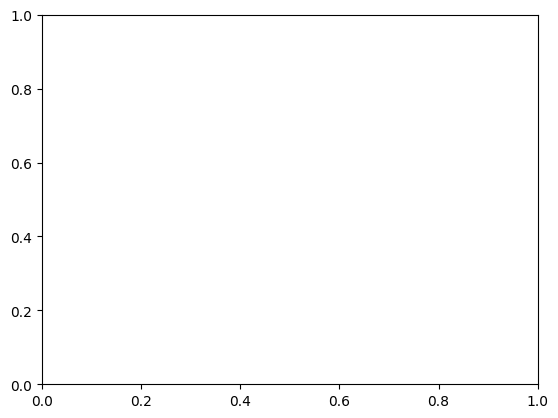

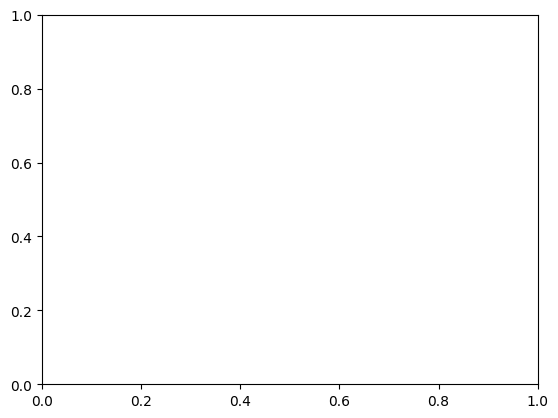

In [39]:
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

generated_image_plot = generated_image[nx,ny][idx_sparse_measurement: idx_sparse_measurement + addition]
snaphot_plot = snapshot[nx,ny][idx_sparse_measurement: idx_sparse_measurement + addition]

ax.plot(generated_image_plot)
ax.plot(snaphot_plot)
ax.set_xlabel("Index")
ax.set_ylabel(r"$\omega$")
ax.legend(["Ground Truth", "Generated Sample"])


rel_error = 100 * np.abs((snapshot[nx,ny] - generated_image[..., nx, ny])/snapshot[nx,ny])
rel_error_plot = rel_error[idx_sparse_measurement:idx_sparse_measurement + addition]
print(rel_error.shape)
ax2.plot(rel_error_plot)
ax2.set_xlabel("Index")
ax2.set_ylabel("Relative Error")
ax2.set_yscale("log")
index_max_rel_error = np.where(rel_error_plot == np.max(rel_error_plot))
print(np.sum(rel_error_plot < 50))
print(index_max_rel_error, rel_error_plot[index_max_rel_error])
print(snaphot_plot[index_max_rel_error], generated_image_plot[index_max_rel_error])
#print(generated_image.shape)
#plt.plot(rel_error[5, 30:100])
#plt.plot(np.mean(test_snapshots[trajectory, :,  nx, ny], axis=-1).shape)
fig.savefig("plots/LinePlot.png", dpi=400)
fig2.savefig("plots/Relative_Error.png", dpi=400)

(220, 256, 256)
(4, 128) ['Ground Truth', 't=50', 't=100', 't=200', 't=400']


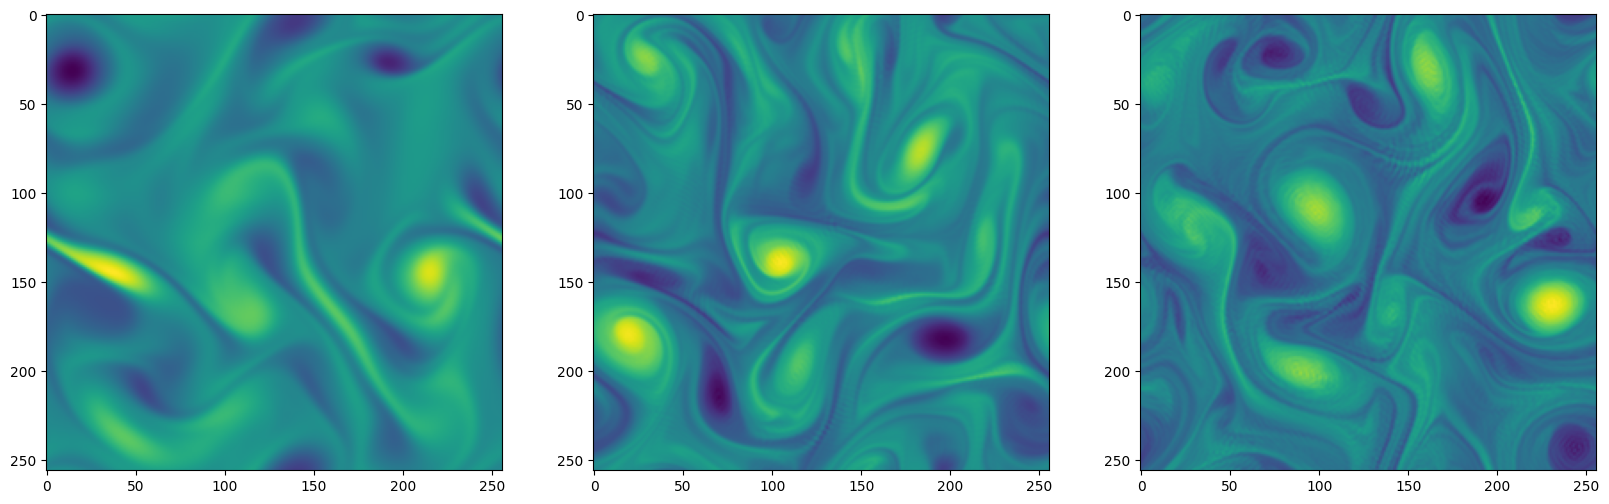

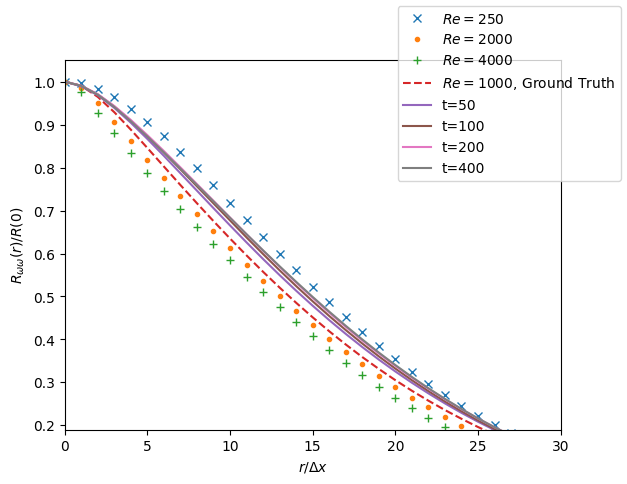

In [85]:
omega_hat_re_250 = np.load("/home/baris/Documents/DDSim/baris-personal/kolmogorov_solver_results/jax-cfd/kolmogorov_Re_250.npy", allow_pickle=True)
omega_hat_re_1000 = np.load("/home/baris/Documents/DDSim/baris-personal/kolmogorov_solver_results/jax-cfd/kolmogorov_Re_1000.npy", allow_pickle=True)
omega_hat_re_2000 = np.load("/home/baris/Documents/DDSim/baris-personal/kolmogorov_solver_results/jax-cfd/kolmogorov_Re_2000.npy", allow_pickle=True)
omega_hat_re_4000 = np.load("/home/baris/Documents/DDSim/baris-personal/kolmogorov_solver_results/jax-cfd/kolmogorov_Re_4000.npy", allow_pickle=True)

omega_re_250 = np.fft.irfftn(omega_hat_re_250, axes=(1,2))
omega_re_1000 = np.fft.irfftn(omega_hat_re_1000, axes=(1,2))
omega_re_2000 = np.fft.irfftn(omega_hat_re_2000, axes=(1,2))
omega_re_4000 = np.fft.irfftn(omega_hat_re_4000, axes=(1,2))
print(omega_re_2000[100:].shape)
start_idx = 0
two_point_correlation_250 = two_point_corr(omega_re_250[start_idx:], axis=1)
#two_point_correlation_1000 = two_point_corr(omega_re_1000[start_idx:], axis=1)
start_idx = 100
two_point_correlation_2000 = two_point_corr(omega_re_2000[start_idx:], axis=1)
two_point_correlation_4000 = two_point_corr(omega_re_4000[start_idx:], axis=1)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
fig2, ax2 = plt.subplots()

#print(omega_re_1000.shape, two_point_correlation.shape)
ax2.plot(two_point_correlation_250, "x")
#plt.plot(two_point_correlation_1000)
#plt.plot(two_point_correlation_1000, "o", markersize=1)
ax2.plot(two_point_correlation_2000, "o", markersize=3)
ax2.plot(two_point_correlation_4000, "+")
ax2.plot(two_point_corr_ground_truth, "--")
ax2.plot(two_point_corr_array.T)
ax2.set_xlabel(r"$r/\Delta x$")
ax2.set_ylabel(r"$R_{\omega\omega}(r)/R(0)$")

print(two_point_corr_array.shape, legend)
legend_correlation = [r"$Re=250$", r"$Re=2000$", r"$Re=4000$"] + legend
legend_correlation[3] = r"$Re=1000 \text{, Ground Truth}$"

fig2.legend(legend_correlation)
ax2.set_xlim([0, 30.0])
ax2.set_ylim([0.19, 1.05])
#ax2.plot(0.2*np.ones((30,)))

ax[0].imshow(omega_re_250[-1])
ax[1].imshow(omega_re_2000[-1])
ax[2].imshow(omega_re_4000[-1])

fig2.savefig("plots/Correlation.png", dpi=400)

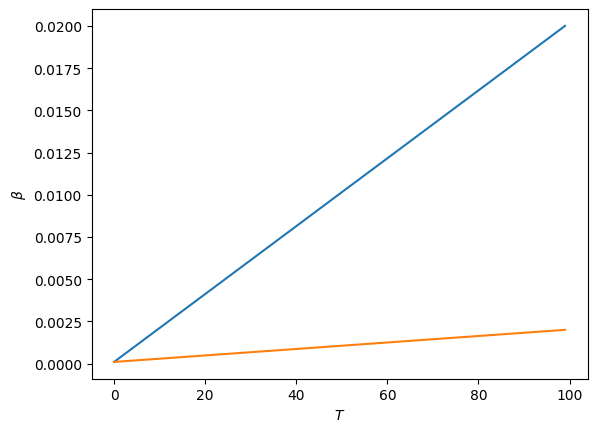

In [4]:
beta_1 = np.linspace(1e-4, 0.02, 100)
beta_2 =  np.linspace(1e-4, 0.002, 100)
plt.plot(beta_1)
plt.plot(beta_2)

plt.xlabel(r"$T$")
plt.ylabel(r"$\beta$")
plt.savefig("Beta_Plot.png", dpi=400)